In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas_profiling as profile
from collections import OrderedDict, Counter
import plotly.express as px
import plotly.graph_objects as go
import re 
import sys
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('../scripts/')
pd.set_option('max_colwidth', 1000)
import hcmst_lib as lib

In [3]:
data = pd.read_stata('../data/HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.set_index('CaseID', inplace=True)

In [4]:
data_dict = pd.read_csv('../data/final_data_dict.csv')
data_dict.set_index('Column Name', inplace=True)

In [5]:
baseline_fields = ['ppgender', 'ppethm', 'ppeduc', 'ppincimp', 'ppmarit'
                   , 'ppreg9', 'ppmsacat', 'ppwork', 'ppage']
data['ppage'] = data['ppage'].astype('float')

In [6]:
data_dict.loc[baseline_fields]

,Description
Column Name,
ppgender,Gender
ppethm,Race / Ethnicity
ppeduc,Education (Highest Degree Received)
ppincimp,Household Income
ppmarit,Marital Status
ppreg9,Region 9 - Based on State of Residence
ppmsacat,MSA Status PPREG4
ppwork,Current Employment Status
ppage,Age ppagecat


In [7]:
# Have useable dictionary for data set percentages 
baseline_pcts = OrderedDict()
for group in baseline_fields:
    baseline_pcts[group] = data[group].value_counts(normalize=True)

In [8]:
groups = [(18, 24),
 (25, 29),
 (30, 34),
 (35, 39),
 (40, 44),
 (45, 49),
 (50, 54),
 (55, 59),
 (60, 64),
 (65, 69),
 (70, 74),
 (75, 79),
 (80, 84)]

def assign_group(n, grp_set_list, grp_index, n_index):
    
    grp = grp_set_list[grp_index]
    
    rslt = np.where(grp[0] <= n <= grp[1], str(grp), False).tolist()
    if rslt[0] == '(':
        return(rslt)
    elif grp_index < (n_index-1) :
        grp_index = grp_index + 1
        rslt = assign_group(n, grp_set_list, grp_index, len(grp_set_list))
        return(rslt)
    else:
        return "Not in group list"

In [9]:
data['age_group'] = data['ppage'].apply(assign_group, grp_set_list=groups, grp_index=0, n_index=len(groups))
data['age_group'] = data['age_group'].astype('category')
data['age_group'].value_counts()

(55, 59)             417
(25, 29)             410
(60, 64)             379
(50, 54)             335
(40, 44)             272
(35, 39)             272
(65, 69)             267
(18, 24)             254
(30, 34)             251
(45, 49)             233
(70, 74)             222
(75, 79)             124
(80, 84)              47
Not in group list     27
Name: age_group, dtype: int64

In [10]:
q_name = 'w6_q32'
data_dict.loc[q_name].str.replace('\s{2,}', ' ')

Description    did you use an Internet service to meet partner? 
Name: w6_q32, dtype: object

In [11]:
data.shape

(3510, 285)

In [12]:
data["flag internet service to meet partner"] = np.where(data['w6_q32'].str.startswith('No, ') == True, 1, 0)
data["flag internet service to meet partner"].value_counts()

1    2920
0     590
Name: flag internet service to meet partner, dtype: int64

## Begin ML Process

In [13]:
import xgboost as xg
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder


In [14]:
baseline_fields.append('age_group')
if 'ppage' in baseline_fields:
    baseline_fields.remove('ppage')
baseline_fields = list(set(baseline_fields))
data[baseline_fields].dtypes

age_group    category
ppwork       category
ppincimp     category
ppgender     category
ppethm       category
ppmarit      category
ppeduc       category
ppmsacat     category
ppreg9       category
dtype: object

In [54]:
data2 = data.copy()
encoders = {}
for x in baseline_fields:
    if data2[x].dtypes == 'category':
        temp_encoder = LabelEncoder().fit(data2[x])
        data2[x] = temp_encoder.transform(data2[x]).reshape(-1, 1)
        encoders[x] = temp_encoder

In [37]:
X = data2[baseline_fields]
y = data2["flag internet service to meet partner"].astype('category')

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 
  
# train_X = xg.DMatrix(train_X, enable_categorical=True)
# Instantiation 
xgb_r = xg.XGBClassifier(objective ='binary:logistic'
                         , n_estimators = 15, max_depth=3 
                         , seed = 123) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
train_preds = xgb_r.predict_proba(train_X)
train_preds = pd.concat([train_X
                         , train_y.astype('float')
                         , pd.Series(train_preds[:, 1], index=train_X.index, name='pred')
                        ], axis=1)


# Predict the model 
pred = xgb_r.predict_proba(test_X, ) 
test_preds = pd.concat([test_X
                        , test_y.astype('float')
                        , pd.Series(pred[:,1], index=test_X.index, name='pred')
                       ], axis=1)



[04:43:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
test_preds.head()

,age_group,ppwork,ppincimp,ppgender,ppethm,ppmarit,ppeduc,ppmsacat,ppreg9,flag internet service to meet partner,pred
CaseID,,,,,,,,,,,
3807,11,4,12,0,4,0,13,0,0,1.0,0.953645
2388,3,5,15,1,4,2,9,0,5,1.0,0.851679
4243,7,0,20,0,2,0,13,0,0,1.0,0.739494
868,1,5,15,0,4,2,8,0,5,1.0,0.828801
1148,6,3,13,0,4,2,8,0,0,1.0,0.918271


In [39]:
train_auc = roc_auc_score(train_preds['flag internet service to meet partner'], train_preds['pred'])

In [83]:
test_auc = roc_auc_score(test_preds['flag internet service to meet partner'], test_preds['pred'])
train_auc = roc_auc_score(train_preds['flag internet service to meet partner'], train_preds['pred'])
aucs = {'Train':np.round(100*train_auc, 2)
        , 'Test':np.round(100*test_auc, 2)
        , 'Diff':np.round(100 * (1-train_auc/test_auc), 2) }
aucs

{'Train': 79.17, 'Test': 75.2, 'Diff': -5.28}

In [41]:
# Test
fpr_tpr  = \
    roc_curve(test_preds['flag internet service to meet partner'], test_preds['pred'])
fpr_tpr_df = pd.DataFrame({'False Positive Rate': fpr_tpr[0]
                           , 'True Positive Rate': fpr_tpr[1]})
fpr_tpr_df['Line Source'] = 'Test AUC'
# Train
train_fpr_tpr  = \
    roc_curve(train_preds['flag internet service to meet partner'], train_preds['pred'])
train_fpr_tpr_df = pd.DataFrame({'False Positive Rate': train_fpr_tpr[0]
                           , 'True Positive Rate': train_fpr_tpr[1]})
train_fpr_tpr_df['Line Source'] = 'Train AUC'
# Baseline
temp_df = pd.DataFrame({ 'False Positive Rate':fpr_tpr_df['False Positive Rate']
                        ,'True Positive Rate':fpr_tpr_df['False Positive Rate']})
temp_df['Line Source'] = '45 Degree Line'

stacked = pd.concat([fpr_tpr_df, train_fpr_tpr_df, temp_df])
stacked.head()

,False Positive Rate,True Positive Rate,Line Source
0,0.000000,0.000000,Test AUC
1,0.000000,0.003417,Test AUC
2,0.000000,0.004556,Test AUC
3,0.005714,0.023918,Test AUC
4,0.005714,0.029613,Test AUC


In [42]:
px.line(stacked, 'False Positive Rate', 'True Positive Rate', color='Line Source')

In [43]:
lib.decile_tbl(test_preds['flag internet service to meet partner']
               , test_preds['pred'] )

,count,min_score,max_score,avg_score,# of Positive Responders,% of Positive Responders,Cumulative Responders,Cumulative Capture Rate,Actual % Pos - Avg(83.04%),Actual % Pos - Decile Avg Score
decile_cuts,,,,,,,,,,
1,106.0,0.0,0.0,0.000,76.998962,72.64,874.406815,100.00,-10.400,72.64
2,105.0,0.0,100.0,34.290,81.981400,78.08,797.407852,91.19,-4.960,43.79
3,105.0,100.0,100.0,100.000,88.281082,84.08,715.426453,81.82,1.040,-15.92
4,105.0,100.0,100.0,100.000,87.766922,83.59,627.145370,71.72,0.550,-16.41
5,106.0,100.0,100.0,100.000,90.106781,85.01,539.378448,61.69,1.970,-14.99
6,105.0,100.0,100.0,100.000,88.410622,84.20,449.271667,51.38,1.160,-15.80
7,105.0,100.0,100.0,100.000,89.037086,84.80,360.861046,41.27,1.760,-15.20
8,105.0,100.0,100.0,100.000,90.703918,86.38,271.823959,31.09,3.340,-13.62
9,105.0,100.0,100.0,100.000,91.453682,87.10,181.120041,20.71,4.060,-12.90


In [44]:
lib.decile_tbl(train_preds['flag internet service to meet partner']
               , train_preds['pred'] )

,count,min_score,max_score,avg_score,# of Positive Responders,% of Positive Responders,Cumulative Responders,Cumulative Capture Rate,Actual % Pos - Avg(82.83%),Actual % Pos - Decile Avg Score
decile_cuts,,,,,,,,,,
1,246.0,0.0,0.0,0.00,172.901031,70.28,2035.059540,100.00,-12.550,70.28
2,246.0,0.0,100.0,31.30,187.948761,76.40,1862.158508,91.50,-6.430,45.10
3,245.0,100.0,100.0,100.00,207.249924,84.59,1674.209747,82.27,1.760,-15.41
4,246.0,100.0,100.0,100.00,210.768829,85.68,1466.959824,72.08,2.850,-14.32
5,246.0,100.0,100.0,100.00,210.484985,85.56,1256.190994,61.73,2.730,-14.44
6,245.0,100.0,100.0,100.00,208.829590,85.24,1045.706009,51.38,2.410,-14.76
7,246.0,100.0,100.0,100.00,208.786560,84.87,836.876419,41.12,2.040,-15.13
8,245.0,100.0,100.0,100.00,206.611908,84.33,628.089859,30.86,1.500,-15.67
9,246.0,100.0,100.0,100.00,208.287552,84.67,421.477951,20.71,1.840,-15.33


In [45]:
train_preds.describe()

,age_group,ppwork,ppincimp,ppgender,ppethm,ppmarit,ppeduc,ppmsacat,ppreg9,flag internet service to meet partner,pred
count,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000
mean,5.298331,4.265364,9.960521,0.496133,3.309320,2.071225,9.025641,0.135938,4.080586,0.831095,0.828270
std,3.356549,1.479086,6.205072,0.500087,1.179168,1.016263,2.894408,0.342793,2.609651,0.374744,0.128681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435311
25%,2.000000,4.000000,4.000000,0.000000,3.000000,2.000000,8.000000,0.000000,2.000000,1.000000,0.758808
50%,6.000000,5.000000,11.000000,0.000000,4.000000,2.000000,9.000000,0.000000,5.000000,1.000000,0.859421
75%,8.000000,5.000000,16.000000,1.000000,4.000000,3.000000,10.000000,0.000000,6.000000,1.000000,0.930774
max,13.000000,6.000000,20.000000,1.000000,4.000000,5.000000,13.000000,1.000000,8.000000,1.000000,0.983787


## Model Explainer

In [46]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import gc

In [78]:
import psutil
m = psutil.virtual_memory()
print(m.available/(1024.0 ** 3) )

0.44759368896484375


In [48]:
gc.collect()

580

In [57]:
encoders['age_group'].inverse_transform([4])

array(['(40, 44)'], dtype=object)

In [75]:
xgb_r.get_booster()[2].get_dump()

['0:[f0<4.5] yes=1,no=2,missing=1\n\t1:[f5<2.5] yes=3,no=4,missing=3\n\t\t3:[f5<1.5] yes=7,no=8,missing=7\n\t\t\t7:leaf=0.121426098\n\t\t\t8:leaf=0.236336723\n\t\t4:[f2<2.5] yes=9,no=10,missing=9\n\t\t\t9:leaf=0.21772258\n\t\t\t10:leaf=0.0339436494\n\t2:[f5<1.5] yes=5,no=6,missing=5\n\t\t5:[f0<9.5] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.183924854\n\t\t\t12:leaf=0.349937916\n\t\t6:[f5<2.5] yes=13,no=14,missing=13\n\t\t\t13:leaf=0.343358338\n\t\t\t14:leaf=0.226127997\n']

In [58]:
dir(xgb_r)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_features_count',
 '_get_param_names',
 '_get_tags',
 '_le',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_evaluation_result',
 '_validate_data',
 '_wrap_evaluation_matrices',
 'apply',
 'base_score',
 'booster',
 'classes_',
 'coef_',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'evals_result',
 'feature_importances_',
 'fit',
 'gamma',
 'get_booster',
 'get_num_boosting_rounds',
 'get_params',
 'get_xgb_params',
 'gpu_id',
 'importance_type',
 'interaction_constraints',
 'inter

In [91]:
xgb_r.n_estimators

15

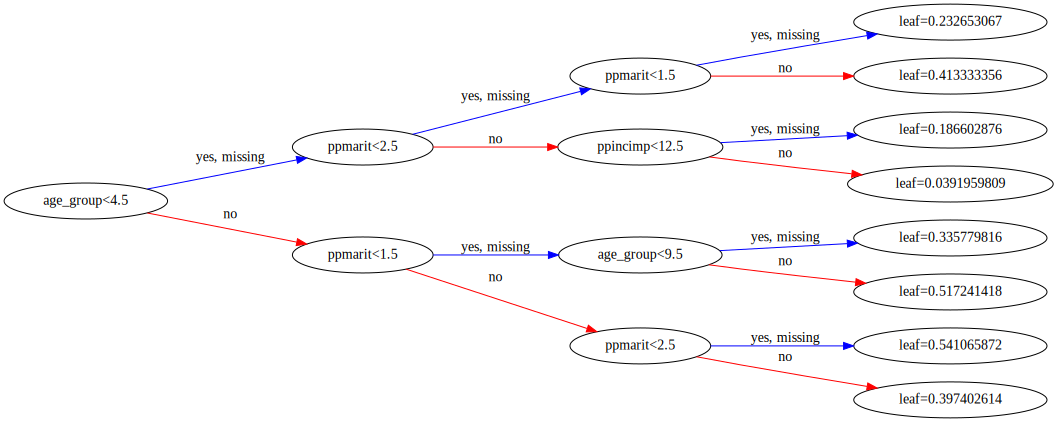

In [96]:
gvz = xg.to_graphviz(xgb_r, num_trees=0, rankdir='LR', )
gvz

In [77]:
feat_imps = {name:imp for name, imp in zip(train_X.columns, xgb_r.feature_importances_)}
feat_imps = pd.Series(feat_imps).sort_values(ascending=False)
feat_imps

age_group    0.337844
ppmarit      0.170909
ppwork       0.096674
ppethm       0.089536
ppgender     0.089253
ppincimp     0.079170
ppeduc       0.078072
ppreg9       0.058543
ppmsacat     0.000000
dtype: float64

In [86]:
data['ppmarit'].value_counts(normalize=True)

Married                0.565812
Never married          0.202849
Divorced               0.093447
Living with partner    0.078917
Widowed                0.039316
Separated              0.019658
Name: ppmarit, dtype: float64